<a href="https://colab.research.google.com/github/abdulazeem/NER-Classification-using-LSTM-in-Keras/blob/master/NER_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.2.0-rc3
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [3]:
data=pd.read_csv('ner_dataset.csv', encoding='latin1')
data=data.fillna(method='ffill')
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [4]:
print('Unique Words in Corpus', data['Word'].nunique())

print('Unique Tags in Corpus', data['Tag'].nunique())

Unique Words in Corpus 31580
Unique Tags in Corpus 17


In [0]:
words = list(set(data['Word'].values))
words.append('ENDPAD')
num_words = len(words)

In [0]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)

In [7]:
tags

['I-per',
 'B-nat',
 'B-eve',
 'I-nat',
 'B-org',
 'I-gpe',
 'I-art',
 'B-tim',
 'I-geo',
 'B-art',
 'O',
 'I-eve',
 'B-per',
 'I-tim',
 'I-org',
 'B-geo',
 'B-gpe']

In [8]:
num_words, num_tags

(31581, 17)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [0]:
class SentenceGetter(object):
  def __init__(self, data):
    self.n_sent=1
    self.data=data
    agg_func=lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), 
                                                     s['POS'].values.tolist(), 
                                                     s['Tag'].values.tolist())]
    self.grouped = self.data.groupby('Sentence #').apply(agg_func) 
    self.sentences = [s for s in self.grouped]                   



In [10]:
getter = SentenceGetter(data)
sentences = getter.sentences
sentences[8]

[('Aid', 'NNP', 'O'),
 ('is', 'VBZ', 'O'),
 ('being', 'VBG', 'O'),
 ('rushed', 'VBN', 'O'),
 ('to', 'TO', 'O'),
 ('the', 'DT', 'O'),
 ('region', 'NN', 'O'),
 (',', ',', 'O'),
 ('but', 'CC', 'O'),
 ('the', 'DT', 'O'),
 ('U.N.', 'NNP', 'B-geo'),
 ('official', 'NN', 'O'),
 ('stressed', 'VBD', 'O'),
 ('that', 'IN', 'O'),
 ('bottlenecks', 'NNS', 'O'),
 ('and', 'CC', 'O'),
 ('a', 'DT', 'O'),
 ('lack', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('infrastructure', 'NN', 'O'),
 ('remain', 'VBP', 'O'),
 ('a', 'DT', 'O'),
 ('challenge', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [0]:
word2idx={w:i+1 for i,w in enumerate(words)}
tag2idx={t:i for i,t in enumerate(tags)}

In [17]:
word2idx

{'grandson': 1,
 'cream': 2,
 'Horn': 3,
 'Discussions': 4,
 'yet': 5,
 'reverse': 6,
 'numbness': 7,
 'Kaesong': 8,
 'faulty': 9,
 '1,44,000': 10,
 'Belt': 11,
 'War-shattered': 12,
 'left-wing': 13,
 'colonial': 14,
 'shah': 15,
 'Khurshid': 16,
 'Tisdale': 17,
 'Al-Shabab': 18,
 'Slim': 19,
 'should': 20,
 'informant': 21,
 'Airlines': 22,
 'bracing': 23,
 'signs': 24,
 '275-seat': 25,
 'Chacon': 26,
 'grass-court': 27,
 'camouflage': 28,
 'Skipper': 29,
 'return': 30,
 'Torkham': 31,
 'obeyed': 32,
 'weapons-grade': 33,
 'unspent': 34,
 'teaches': 35,
 'privacy': 36,
 'imprisoning': 37,
 '1215': 38,
 '2.7-million': 39,
 'softening': 40,
 'municipalities': 41,
 'timed': 42,
 'pilgrims': 43,
 'Elias': 44,
 'caches': 45,
 'pepper': 46,
 'still': 47,
 'decision-making': 48,
 'depreciated': 49,
 'pro-whaling': 50,
 'March': 51,
 'contends': 52,
 'Egypt': 53,
 '1.27': 54,
 'teargas': 55,
 'Sajida': 56,
 'Barbour': 57,
 'Memorial': 58,
 'Baylesa': 59,
 'arrives': 60,
 'Keesler': 61,
 '59t

### Task 5: Padding Input Sentences and Creating Train/Test Splits

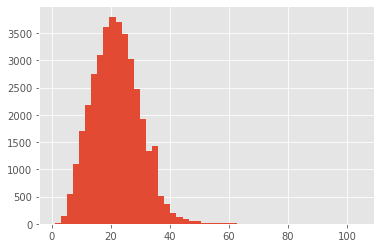

In [12]:
plt.hist([len(s) for s in sentences], bins =50)
plt.show()

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [0]:
max_len=50
X=[[word2idx[w[0]] for w in sentence] for sentence in sentences]
X= pad_sequences(sequences=X, maxlen=max_len, padding='post', value=num_words-1 )

y=[[tag2idx[w[2]] for w in sentence] for sentence in sentences]
y=pad_sequences(sequences=y, maxlen=max_len, padding='post', value=tag2idx['O'])

In [15]:
y=[to_categorical(i, num_classes=num_tags) for i in y]
len(X)

37745

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.1, random_state=1)

In [18]:
len(X_train)

33970

### Task 6: Build and Compile a Bidirectional LSTM Model

In [0]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [20]:
input = Input(shape=max_len)
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1579050   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,703,267
Trainable params: 1,703,267
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics =['accuracy'])

### Task 7: Train the Model

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [24]:
pip install livelossplot

### Task 8: Evaluate Named Entity Recognition Model